In [1]:
import sys, os, pathlib
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))

In [2]:
#some basic imports
import sys, os, copy
import numpy as np
import datetime as dt
import pandas as pd

In [3]:
# construct a dataset with some observations and all kind of mixed lables
nObs = 10000

idx = np.array(list(range(nObs))) + 1000
c0 = np.random.choice(['A','B'], size=nObs)

c1_h = np.random.choice([12,13,14], size=nObs)
c1_d = np.random.choice([0,1], size=nObs)
c1_s = np.random.randint(60, size=nObs)

c1 = []
for i in range(nObs):
    c1.append( dt.datetime(2017,1,1,0,0,0) + dt.timedelta(days=int(c1_d[i]), hours=int(c1_h[i]), minutes=int(c1_s[i])) )

c2 = np.random.choice(['a','b','c'], size=nObs)
c3 = np.round(np.random.rand(nObs), 2)

X = pd.DataFrame({'Device': c0,
             'Time': c1,
             'Label':c2,
             'Cont':c3}, index = idx)

print(X.shape, X.columns)

(10000, 4) Index(['Cont', 'Device', 'Label', 'Time'], dtype='object')


In [4]:
class xthelper():
    j = 0
    def __int__(self):
        pass
    def __call__(self, row):
        dev_dict = {'A':0.3, 'B':0.8}
        label_dict = {'a':0.8, 'b':0.6, 'c':0.7}
        prob =  ( 0.5 + 0.1*c1_d[self.j] - (c1_h[self.j]-12)*0.5 ) * label_dict[row['Label']] + (row['Cont']-0.5)/4
        prob = max(min(1.,prob), 0.)

        self.j+=1
        if row['Device'] == 'A':
            return int(prob>0.3)
        else:
            return int(prob>0.5)
    
y= X.apply(xthelper(), axis=1)

print(y.shape, "coverage %f" % (np.sum(y)/y.shape[0]))

(10000,) coverage 0.146700


In [5]:
#split up dataset into train and (held out)test sample
msk = np.random.rand(len(X)) < 0.8
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

In [6]:
#==== PIPELINE ASSEMBLY
from Learning.Assembly import *
from Learning.GBDTreeLearner import GrowingGBClassifier
from Learning.GeneralTransformers import *

In [7]:
#assemble the pipeline by bits an pieces

#OneHot/Label encoding for feature 'Label'
tf0 = TransformerPipe([
        ('pagehistExtr', ColumnsSelect(['Label'])),
        ('labelEnc', LabelDummyTransformer())
    ])

#Extraction of Hour and Day-of-Month fromfeature  'Time'
tf1 = TransformerPipe([
        ('starttimeExtr', ColumnsSelect('Time')),
        ('hwdmyExtr', HourWeekdayDayMonthYearTransformer()),
        ('hwdselect', ColumnsSelect(['Time_hour', 'Time_day']))
    ])

#assemble a set of to use features
fu = FeatureUnion([
        ('tf0', tf0),
        ('tf1', tf1),
        ('tf2', ColumnsSelect('Cont')) # feature 'Cont' could have been wrapped into its own pipeline,
                                       # but no need to convolute as already in correct format
    ], n_jobs= 1)

#define a Classifier estimator; here one that is smarter as the average by growing additional trees
c0 = GrowingGBClassifier(ntrees_start = 100,
            ntress_increment = 10,
            est_params = {'max_depth': 3,
                          'max_features': None}, #auto
            scoring = 'log_loss',
            min_score_improvement = 1e-5,
            nrounds_noimp = 2,
            nrounds_stop = sys.maxsize,
            cv_test_frac = 0.2, 
            cv_n_splits = 3)

#as we are interested in the probabilities rather than the absolute binary calssification wrap it down once
cc0 = OneProbClassifierWrapper(c0, predictClass=1)

#this is already a complete pipeline, which uses all features except 'Device'
pred_pipe = Pipeline([
        ("fu",fu),
        ("cc0", cc0)
    ])

In [8]:
#OneHot/Label encoding for feature 'Label'

In [9]:
cf = CategoryFork(pred_pipe,
                  'Device',
                  [('A'),('B')],
                  n_jobs=1 )

main_pipe = cf

In [10]:
#train the pipeline
main_pipe.fit(X_train, y_train)

resetting estimator to null-state
call from <Learning.GBDTreeLearner.GrowingGBClassifier object at 0x000001FB5770DB00>
round n_est meter
0 5 -0.300831
1 10 -0.190938
2 15 -0.130914
3 20 -0.093784
4 25 -0.070503
5 30 -0.055837
6 35 -0.046108
7 40 -0.038599
8 45 -0.032150
9 50 -0.027736
10 55 -0.024341
11 60 -0.021410
12 65 -0.018936
13 70 -0.016874
14 75 -0.015136
15 80 -0.013577
16 85 -0.012394
17 90 -0.011370
18 95 -0.010318
19 100 -0.009358
20 105 -0.008617
21 110 -0.007730
22 115 -0.007125
23 120 -0.006559
24 125 -0.005983
25 130 -0.005307
26 135 -0.004770
27 140 -0.004358
28 145 -0.004040
29 150 -0.003767
30 155 -0.003413
31 160 -0.003104
32 165 -0.002866
33 170 -0.002676
34 175 -0.002499
35 180 -0.002309
36 185 -0.002117
37 190 -0.001965
38 195 -0.001808
39 200 -0.001721
40 205 -0.001609
41 210 -0.001519
42 215 -0.001470
43 220 -0.001420
44 225 -0.001356
45 230 -0.001325
46 235 -0.001239
47 240 -0.001118
48 245 -0.001067
49 250 -0.001036
50 255 -0.000943
51 260 -0.000851
52 265 -0

In [11]:
# predict and verify the training by itself:
#this score is a combination of the training scores in each subpipeline in cf
y_train_pred = main_pipe.predict(X_train)
from sklearn.metrics import log_loss
log_loss(y_train, y_train_pred)

8.4153734683744524e-05

In [12]:
#measure performance on the held out data set
y_test_pred = main_pipe.predict(X_test)
from sklearn.metrics import log_loss
log_loss(y_test, y_test_pred)

0.0001863907627979889

In [13]:
from Learning.Metric import *
ClassifierOvertrainCheck(main_pipe, X_train, y_train, X_test, y_test)

RocAuc score :: train: 1.000000  test: 1.000000  diff: -1.110223e-16
LogLoss :: train: 0.000084  test: 0.000186  diff: -1.022370e-04
Adapted LogLoss :: train: -0.417496  test: -0.414325  diff: -3.170837e-03


In [14]:
#look into the category fork and have a re-analysis of the Device=='A' predictions

Xp0_train = X_train.loc[X_train['Device']=='A']
yp0_train = y_train.loc[X_train['Device']=='A']
pred_pipe_0 = cf.pipeline_list_[0]

yp0_train_pred = pred_pipe_0.predict(Xp0_train)

log_loss(yp0_train, yp0_train_pred)

8.1872337177694312e-05

In [15]:
Xp0_test = X_test.loc[X_test['Device']=='A']
yp0_test = y_test.loc[X_test['Device']=='A']
pred_pipe_0 = cf.pipeline_list_[0]

yp0_test_pred = pred_pipe_0.predict(Xp0_test)

log_loss(yp0_test, yp0_test_pred)

0.00027703012679073589

In [16]:
#have a look at the most important features for each pipeline
fi_deep = cf.get_feature_importances_deep()
fi_deep

[('tf1__Time_hour', [0.46934602202352438, 0.33380190712580526]),
 ('tf0__Label_c', [0.06212611346571608, 0.027412135285871601]),
 ('tf0__Label_a', [0.057258423987853586, 0.046018136795468449]),
 ('tf2__Cont', [0.28760686461390039, 0.36265309140530572]),
 ('tf1__Time_day', [0.069223192939917355, 0.13531594254822848]),
 ('tf0__Label_b', [0.042318170847875931, 0.066891810095134452])]

In [17]:
fi = pred_pipe_0.get_feature_importances()
fi

[('tf0__Label_a', 0.057258423987853586),
 ('tf0__Label_b', 0.042318170847875931),
 ('tf0__Label_c', 0.06212611346571608),
 ('tf1__Time_hour', 0.46934602202352438),
 ('tf1__Time_day', 0.069223192939917355),
 ('tf2__Cont', 0.28760686461390039)]

In [18]:
#have a look at the most important features
fi = cf.get_feature_importances()

In [19]:
from Learning.Visualisation import *

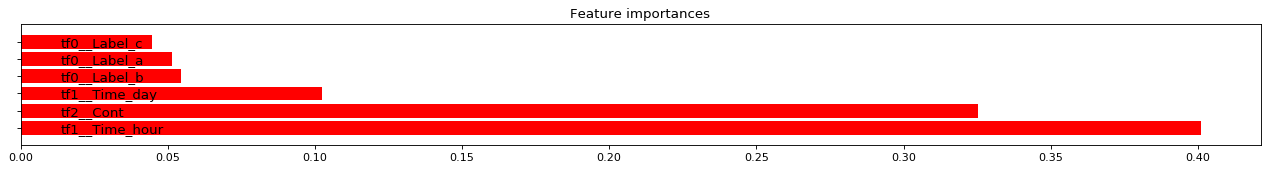

In [20]:
plot_FeatureImportances(main_pipe)

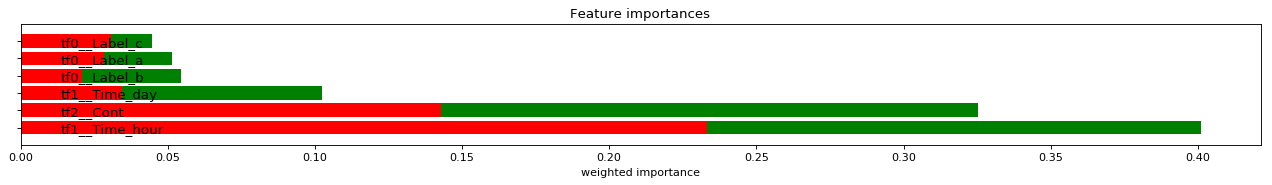

In [21]:
plot_CategoryFork_FeatureImportances(main_pipe)

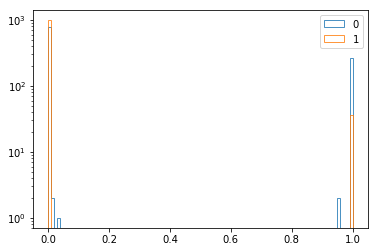

In [23]:
plot_CategoryFork_prediction(main_pipe, X_test)